In [1]:
import pandas as pd
import networkx as nx
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
interactions_validation = pd.read_csv(r'recipes/interactions_validation.csv')
interactions_test = pd.read_csv(r'recipes/interactions_test.csv')
interactions_train = pd.read_csv(r'recipes/interactions_train.csv')

In [15]:
recipes_df = pd.read_csv(r'recipes/RAW_recipes.csv')

recipes_df = recipes_df[recipes_df['ingredients'].apply(len) >= 6]

In [16]:
import ast
recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)

unique_ingredients = set()
for ingredients_list in recipes_df['ingredients']:
    unique_ingredients.update(ingredients_list)

num_unique_ingredients = len(unique_ingredients)

print(f'Number of unique ingredients: {num_unique_ingredients}')

Number of unique ingredients: 14942


In [17]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\vassa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
mapping_df = pd.read_excel('ingredients.xlsx')

In [19]:
ingredient_mapping = dict(zip(mapping_df['raw_ingr'], mapping_df['extracted_ingredient']))

def replace_ingredients(ingredient_list):
    return [ingredient_mapping.get(ingr, ingr) for ingr in ingredient_list]

recipes_df['ingredients'] = recipes_df['ingredients'].apply(replace_ingredients)


In [20]:
all_interactions = pd.concat([interactions_validation, interactions_test, interactions_train])

average_ratings = all_interactions.groupby('recipe_id')['rating'].mean().reset_index()

average_ratings.columns = ['recipe_id', 'average_rating']

In [21]:
ratings_count = all_interactions.groupby('recipe_id')['rating'].count().reset_index()

ratings_count.columns = ['recipe_id', 'num_raters']

average_ratings = average_ratings.merge(ratings_count, on='recipe_id')


recipe_with_ratings = recipes_df.merge(average_ratings, how='left', left_on='id', right_on='recipe_id')

recipe_with_ratings = recipe_with_ratings.drop(columns=['recipe_id'])
recipe_with_ratings['num_raters'] = recipe_with_ratings['num_raters'].fillna(0).astype(int)
recipe_with_ratings['average_rating'] = recipe_with_ratings['average_rating'].fillna(0)

In [23]:
def clean_ingredients(ingredient_list):
    try:
        if isinstance(ingredient_list, str):
            ingredients = ast.literal_eval(ingredient_list)
        else:
            ingredients = ingredient_list

        return [ing.lower().strip() for ing in ingredients if ing.strip()]
    except:
        return []

In [24]:
def create_ingredient_graph(df):
    G = nx.Graph()

    ingredient_cooccurrence = defaultdict(lambda: defaultdict(int))
    ingredient_popularity = defaultdict(list)

    for _, row in df.iterrows():
        ingredients = row['clean_ingredients']
        rating = row['average_rating']
        num_raters = row['num_raters']
        
        for i in range(len(ingredients)):
            for j in range(i+1, len(ingredients)):
                if not G.has_edge(ingredients[i], ingredients[j]):
                    G.add_edge(ingredients[i], ingredients[j], weight=1)
                else:
                    G[ingredients[i]][ingredients[j]]['weight'] += 1
                
                pair = tuple(sorted([ingredients[i], ingredients[j]]))
                ingredient_cooccurrence[pair]['count'] += 1
                ingredient_cooccurrence[pair]['total_rating'] += rating
                ingredient_cooccurrence[pair]['total_raters'] += num_raters
    
    for pair, data in ingredient_cooccurrence.items():
        data['avg_rating'] = data['total_rating'] / data['count'] if data['count'] > 0 else 0
        data['avg_raters'] = data['total_raters'] / data['count'] if data['count'] > 0 else 0
    
    return G, ingredient_cooccurrence


In [25]:
def visualize_ingredient_graph(G, top_n=20):
    top_ingredients = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n]
    top_graph = G.subgraph([ing for ing, _ in top_ingredients])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(top_graph, k=0.5, iterations=50)

    nx.draw(
        top_graph,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=[top_graph.degree(node) * 20 for node in top_graph.nodes()],
        font_size=8,
        edge_color='gray',
        alpha=0.7
    )

    edge_labels = nx.get_edge_attributes(top_graph, 'weight')
    nx.draw_networkx_edge_labels(top_graph, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Top Ingredient Connections")
    plt.tight_layout()
    plt.show()


C:\Users\vassa\AppData\Local\Temp\ipykernel_11544\322525657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_recipes_df['clean_ingredients'] = small_recipes_df['ingredients'].apply(clean_ingredients)
C:\Users\vassa\AppData\Local\Temp\ipykernel_11544\1263557226.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


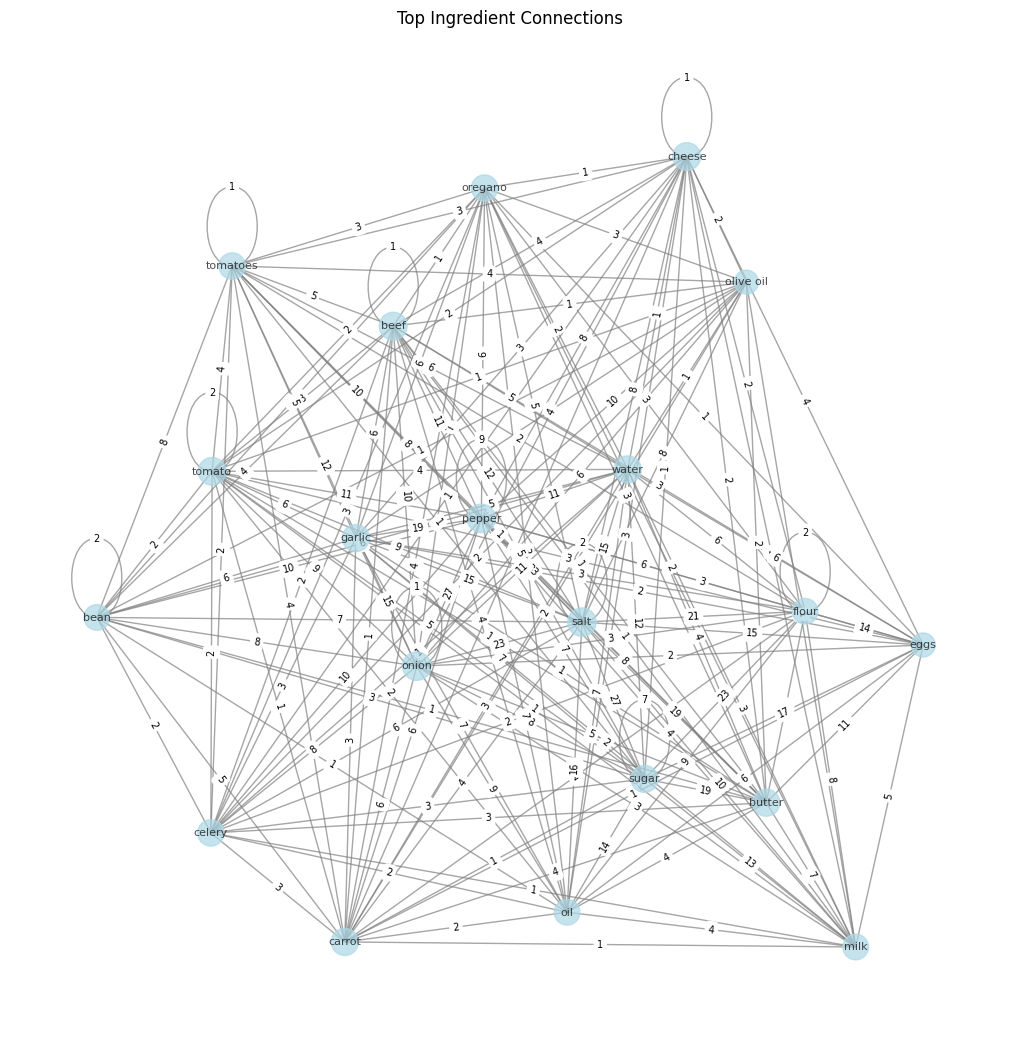

In [ ]:
recipes_df['clean_ingredients'] = recipes_df['ingredients'].apply(clean_ingredients)
ingredient_graph, ingredient_cooccurrence = create_ingredient_graph(recipes_df)

nx.write_gml(ingredient_graph,"graphs/ingredients_weighted_graph")

visualize_ingredient_graph(ingredient_graph)

In [ ]:
import pickle

ingredient_cooccurrence_dict = {key: dict(value) for key, value in ingredient_cooccurrence.items()}

with open("ingredient_cooccurrence.pkl", "wb") as f:
    pickle.dump(ingredient_cooccurrence_dict, f)

print("Ingredient cooccurrence data saved successfully!")

Ingredient cooccurrence data saved successfully!
